In [11]:
%load_ext autoreload
%autoreload 2

In [12]:
PYTHON_PATHS = [".."]
import sys
for path in PYTHON_PATHS:
    if path not in sys.path:
        sys.path.append(path)
        
from imap.data.image_rendering_data_module import ImageRenderingDataModule
from imap.model.nerf import NERF
from imap.utils import UniversalFactory
from pytorch_lightning.utilities.parsing import AttributeDict
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import os
from pathlib import Path
import torch
from tqdm.notebook import tqdm

In [13]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from imap.utils.torch_math import *

# Load images

In [14]:
color_image_path = str(Path("../test_datasets/tum rgbd/rgbd_dataset_freiburg1_desk/rgb/1305031467.695886.png"))
depth_image_path = str(Path("../test_datasets/tum rgbd/rgbd_dataset_freiburg1_desk/depth/1305031464.952471.png"))

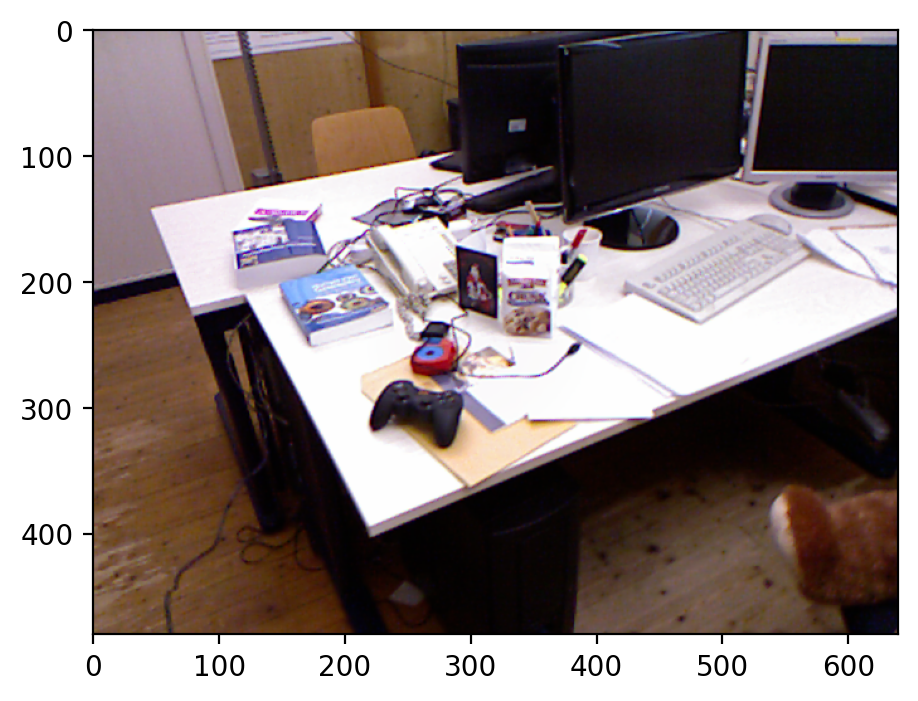

In [15]:
figure = plt.figure(dpi=200)
color_image = cv2.imread(color_image_path)
plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR))

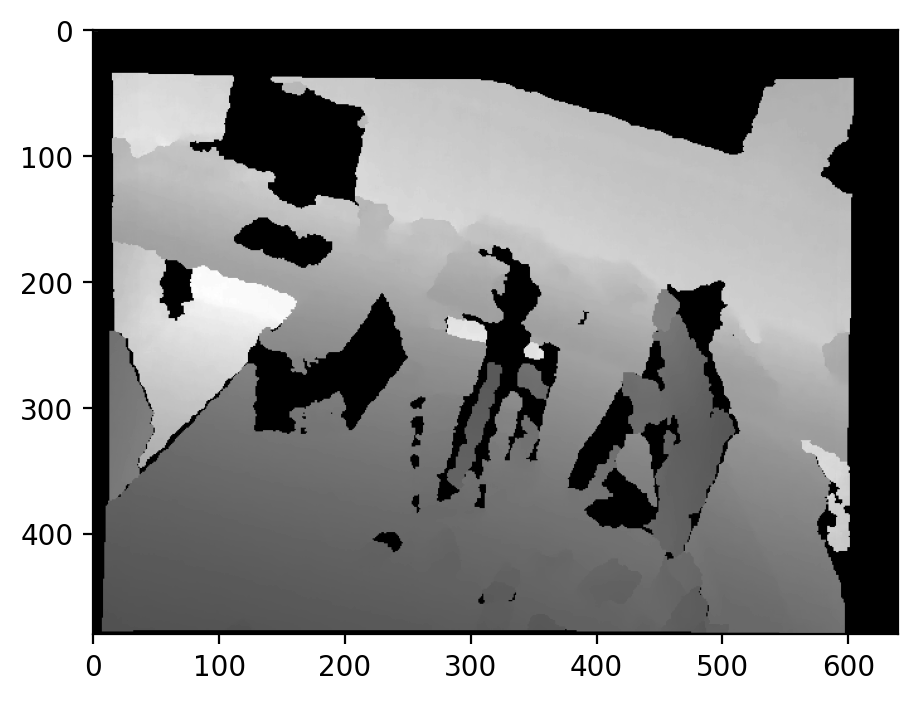

In [16]:
figure = plt.figure(dpi=200)
depth_image = cv2.imread(depth_image_path, -1).astype(np.float32) / 5000
depth_image = np.clip(depth_image, 0, 4)
plt.imshow(depth_image, cmap="gray")

In [17]:
dataset_params = {'dataset_path': "../test_datasets/tum rgbd/", 
                  'scene_name': "rgbd_dataset_freiburg1_desk", 
                  'association_file_name': "data_association_file.txt", 
                  'frame_indices': [131, 257, 325, 407, 455],
#                   'frame_indices': [131, 325],
#                   'frame_indices': [325],
                  'distance_koef': 0.1,
                  'clip_distance_threshold': 4.}
# dataset_params=1
data_module = ImageRenderingDataModule('tum', **dataset_params)

Reading ../test_datasets/tum rgbd/rgbd_dataset_freiburg1_desk/data_association_file.txt
Read (5, 480, 640, 3) images array
Dataset size: 1536000 pixels
[ToyDataModule] - train subset size 1536000


In [18]:
def invert_position(matrix):
    result = np.zeros((3, 4))
    result[:3, :3] = matrix[:3, :3].T
    result[:3, 3:4] = -matrix[:3, :3].T @ matrix[:3, 3:4]
    return result

In [19]:
def get_point_cloud(index, scale=5):
    y, x = np.meshgrid(range(color_image.shape[0] // scale), range(color_image.shape[1] // scale))                       
    int_pixels = (np.array([x, y], dtype=np.int32).T * scale).reshape(-1, 2)
    depths = torch.tensor(data_module._dataset._depth_images[index][int_pixels[:, 1], int_pixels[:, 0]]).float()
    pixels = torch.tensor(int_pixels.astype(np.float32))
    position = data_module._dataset._positions[index]
#     position = invert_position(position)
    position = torch.repeat_interleave(
        torch.tensor(position.astype(np.float32))[None], depths.shape[0], dim=0)
    inverted_camera_matrix = torch.tensor(
        data_module._dataset._camera_info.get_inverted_camera_matrix().astype(np.float32))
    return back_project_pixel(pixels, depths, position, inverted_camera_matrix).cpu().detach().numpy()

In [20]:
points0 = get_point_cloud(0)
points1 = get_point_cloud(3)

In [21]:
# fig = go.Figure(
#     data=[
#         go.Scatter3d(x=points0[:, 0],
#                      y=points0[:, 1], 
#                      z=points0[:, 2],
#                      mode="markers",
#                      name="0",
#                      marker={
#                          "size": 2
#                      }),
#                 go.Scatter3d(x=points1[:, 0],
#                      y=points1[:, 1], 
#                      z=points1[:, 2],
#                      mode="markers",
#                      name="0",
#                      marker={
#                          "size": 2
#                      }),
#     ]
# )
# fig.show()

# Make model

In [22]:
parameters = AttributeDict(
    name="NERF",
    optimizer=AttributeDict(lr=0.005),
    encoding_dimension=93,
    course_sample_bins=32,
    fine_sample_bins=12,
    depth_loss_koef=1.,
    color_loss_koef=5.,
    encoding_sigma=25,
    optimize_positions=False,
    minimal_depth=0.01,
)
factory = UniversalFactory([NERF])
model = factory.make_from_parameters(parameters, camera_info=data_module.camera_info())

In [78]:
# logger_path = os.path.join(os.path.dirname(task.cache_dir), "lightning_logs", "sparse_feature_pyramid")
logger_path = os.path.join("lightning_logs", "sparse_feature_pyramid")
trainer_parameters = {
    "max_epochs": 5,
    "checkpoint_every_n_val_epochs": 10,
    "gpus": 1,
    "check_val_every_n_epoch": 2
}
# task.connect(trainer_parameters)
model_checkpoint = pl.callbacks.ModelCheckpoint(monitor='val_loss',
    every_n_val_epochs=trainer_parameters["checkpoint_every_n_val_epochs"])
trainer = factory.kwargs_function(pl.Trainer)(
    logger=TensorBoardLogger(logger_path, name="chess"),
    callbacks=[],
    **trainer_parameters
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [79]:
# import os
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [80]:
trainer.fit(model, data_module);

/home/quetalasj/miniconda3/envs/pytorch3d/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type                       | Params
--------------------------------------------------------------------
0 | _mlp                 | MLP                        | 246 K 
1 | _positional_encoding | GaussianPositionalEncoding | 279   
2 | _loss                | L1Loss                     | 0     
--------------------------------------------------------------------
246 K     Trainable params
0         Non-trainable params
246 K     Total params
0.986     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/home/quetalasj/miniconda3/envs/pytorch3d/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


In [13]:
# torch.save(model.state_dict(), "test_l1.pth");

In [14]:
# model.load_state_dict(torch.load("test_l1.pth"))

# New architecture

In [140]:
from IPython.display import clear_output

In [141]:
from imap.trainers.trainers import ModelTrainer

In [149]:
model2 = factory.make_from_parameters(parameters, camera_info=data_module.camera_info())

In [150]:

trainer = ModelTrainer()
for i in range(1):
    clear_output(wait=True)
    trainer.train(model2, data_module.train_dataloader())
    

loss: 3.247972249984741
loss: 2.4248156547546387
loss: 2.130765676498413
loss: 1.8851730823516846
loss: 1.7755467891693115
loss: 1.7903237342834473
loss: 1.7577224969863892
loss: 1.723179817199707
loss: 1.6855013370513916
loss: 1.6952483654022217
loss: 1.6066721677780151
loss: 1.5775494575500488
loss: 1.5604360103607178
loss: 1.5044218301773071
loss: 1.5154005289077759
loss: 1.497815489768982
loss: 1.4866106510162354
loss: 1.4507298469543457
loss: 1.4105093479156494
loss: 1.3929742574691772
loss: 1.350205659866333
loss: 1.3140320777893066
loss: 1.296419382095337
loss: 1.2745378017425537
loss: 1.2432892322540283
loss: 1.1957037448883057
loss: 1.195052146911621
loss: 1.1567308902740479
loss: 1.169359803199768
loss: 1.156813144683838
loss: 1.152639627456665
loss: 1.114809274673462
loss: 1.088952898979187
loss: 1.077075719833374
loss: 1.093630313873291
loss: 1.0462894439697266
loss: 1.073240041732788
loss: 1.0618211030960083
loss: 1.0553028583526611
loss: 1.0589629411697388
loss: 1.0277280

# Show the results

In [60]:
from scipy.spatial.transform import Rotation

In [61]:
def get_position(translation, rotation):
    matrix_position = np.eye(4)
    matrix_position[:3, 3] = translation
    matrix_position[:3, :3] = Rotation.from_euler("xyz", rotation).as_matrix()
    return matrix_position

In [62]:
scale = 1
y, x = np.meshgrid(range(color_image.shape[0] // scale), range(color_image.shape[1] // scale))                       
pixels = np.array([x, y], dtype=np.float32).T * scale
pixels = torch.tensor(pixels).cuda().reshape(-1, 2)
# position = get_position(np.array([0, 0, 0]), np.array([0, 0, 0]))
position = data_module._dataset._positions[3]
# delta_position = get_position(np.array([0, 0, 0.5]), np.array([0, 0, 0]))
# position = get_position(np.array([0.013575  , -0.03508   ,  0.17796502]), 
#                           np.array([-2.18386447, -0.20961459,  0.11297752]))
# delta_position = get_position(np.array([0, 0, -0.05]), np.array([0, -0.3, 0]))
# position =  position @ delta_position
positions = torch.repeat_interleave(torch.tensor(position.astype(np.float32))[None], pixels.shape[0],
                                  dim=0).cuda()

In [81]:
batch_size = 4096
batch_count = pixels.shape[0] // batch_size
output_course_color = []
output_course_depth = []
output_fine_color = []
output_fine_depth = []
model = model.cuda()
model.eval()
with torch.no_grad():
    for i in tqdm(range(batch_count)):
        output = model(pixels[i * batch_size:i * batch_size + batch_size],
                             positions[i * batch_size:i * batch_size + batch_size])
        output_course_color.append(output[0])
        output_course_depth.append(output[1])
        output_fine_color.append(output[2])
        output_fine_depth.append(output[3])

  0%|          | 0/75 [00:00<?, ?it/s]

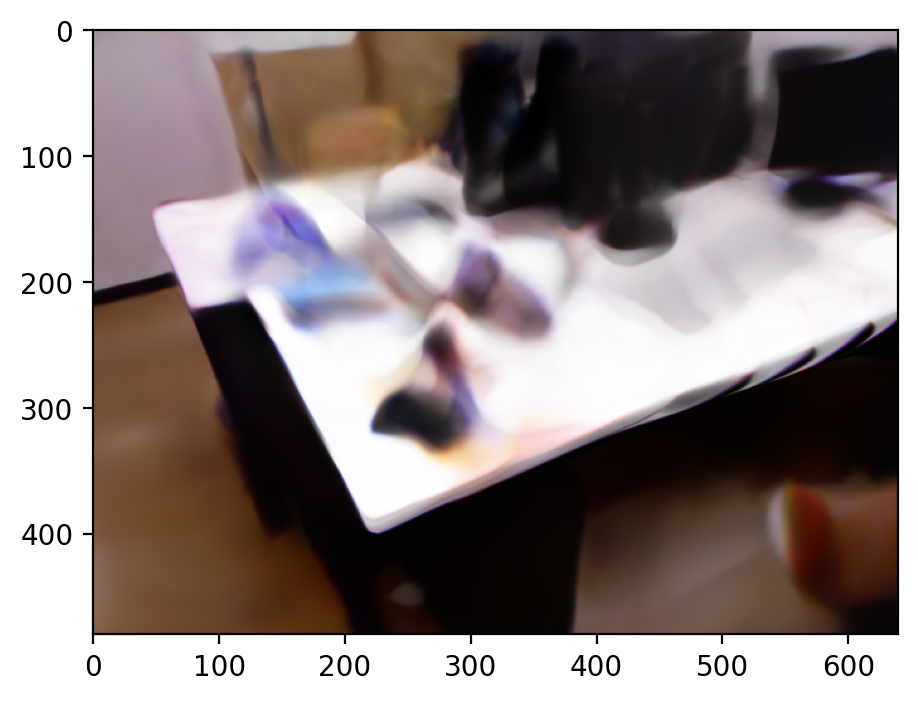

In [82]:
reconstructed_image = torch.cat(output_course_color, dim=0).reshape(480 // scale, 640 // scale, 3).detach().cpu().numpy()
mean = data_module.camera_info()._color_mean
std = data_module.camera_info()._color_std
reconstructed_image = reconstructed_image * std[None, None] + mean[None, None]
reconstructed_image = np.clip(reconstructed_image / 255., 0, 1)
figure = plt.figure(dpi=200)
plt.imshow(cv2.cvtColor(reconstructed_image.astype(np.float32), cv2.COLOR_RGB2BGR))

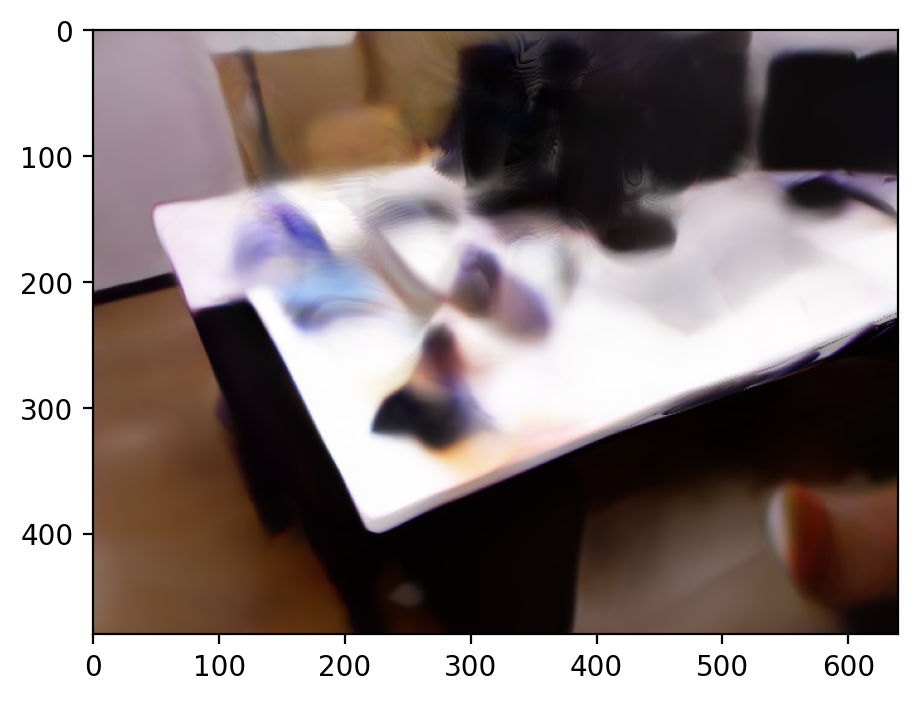

In [83]:
reconstructed_image = torch.cat(output_fine_color, dim=0).reshape(480 // scale, 640 // scale, 3).detach().cpu().numpy()
mean = data_module.camera_info()._color_mean
std = data_module.camera_info()._color_std
reconstructed_image = reconstructed_image * std[None, None] + mean[None, None]
reconstructed_image = np.clip(reconstructed_image / 255., 0, 1)
figure = plt.figure(dpi=200)
plt.imshow(cv2.cvtColor(reconstructed_image.astype(np.float32), cv2.COLOR_RGB2BGR))

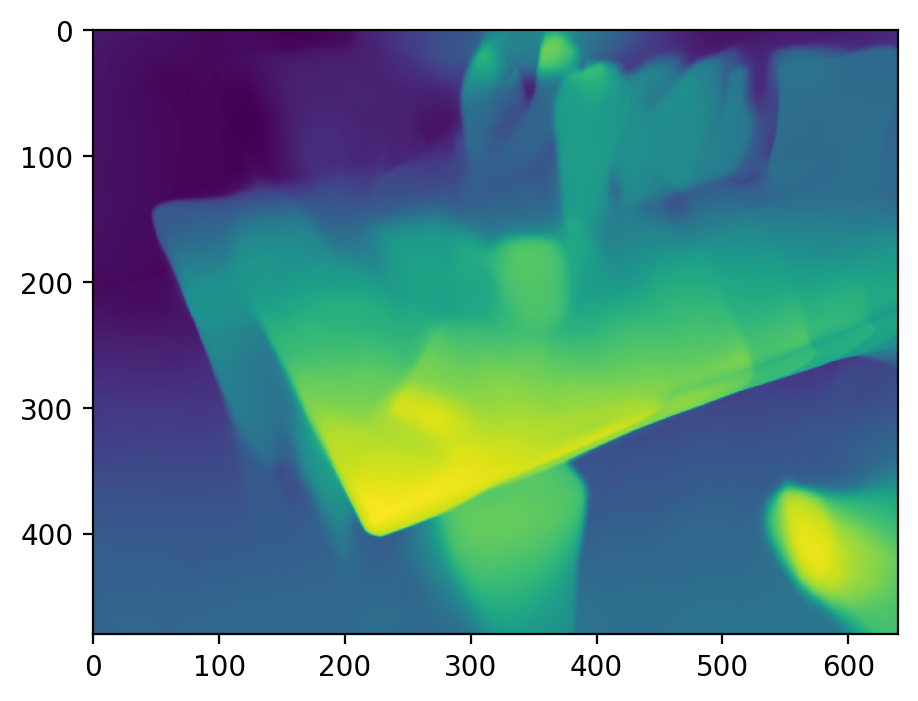

In [84]:
reconstructed_depth = torch.cat(output_course_depth, dim=0).reshape(480 // scale, 640 // scale).detach().cpu().numpy()
figure = plt.figure(dpi=200)
plt.imshow(1. /reconstructed_depth)

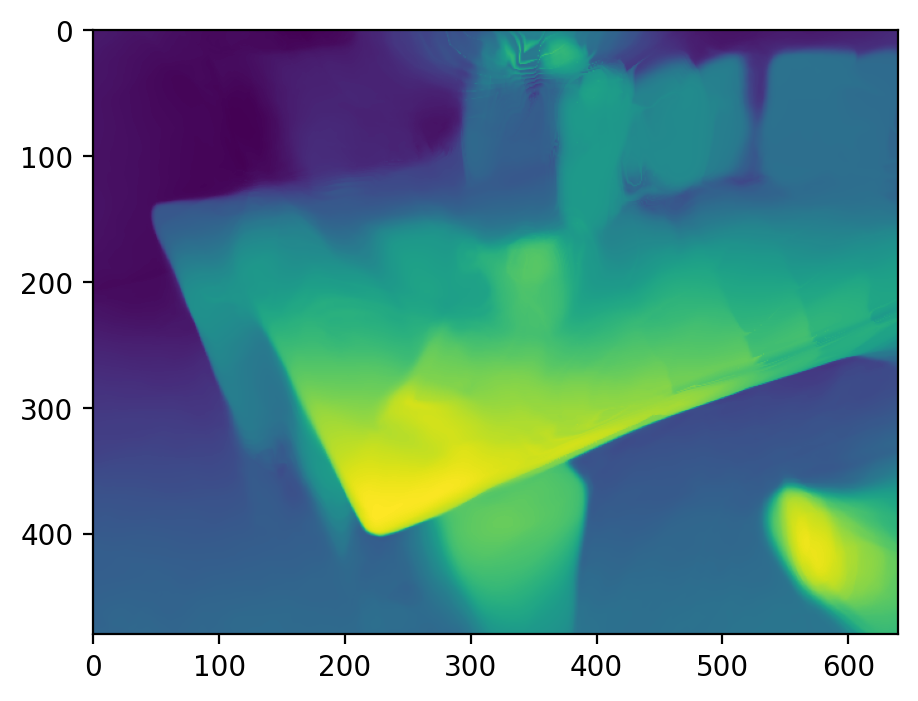

In [85]:
reconstructed_depth = torch.cat(output_fine_depth, dim=0).reshape(480 // scale, 640 // scale).detach().cpu().numpy()
figure = plt.figure(dpi=200)
plt.imshow(1. /reconstructed_depth)

In [94]:
model2.to('cuda')

NERF(
  (_mlp): MLP(
    (first_layer): Sequential(
      (0): Linear(in_features=93, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
    )
    (last_layers): Sequential(
      (0): Linear(in_features=349, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=4, bias=True)
    )
  )
  (_positional_encoding): GaussianPositionalEncoding(
    (_b_encoding_matrix): Linear(in_features=3, out_features=93, bias=False)
  )
  (_loss): L1Loss()
)

In [151]:
batch_size = 4096
batch_count = pixels.shape[0] // batch_size
output_course_color = []
output_course_depth = []
output_fine_color = []
output_fine_depth = []
model = model.cuda()
model.eval()
with torch.no_grad():
    for i in tqdm(range(batch_count)):
        output = model2(pixels[i * batch_size:i * batch_size + batch_size],
                             positions[i * batch_size:i * batch_size + batch_size])
        output_course_color.append(output[0])
        output_course_depth.append(output[1])
        output_fine_color.append(output[2])
        output_fine_depth.append(output[3])

  0%|          | 0/75 [00:00<?, ?it/s]

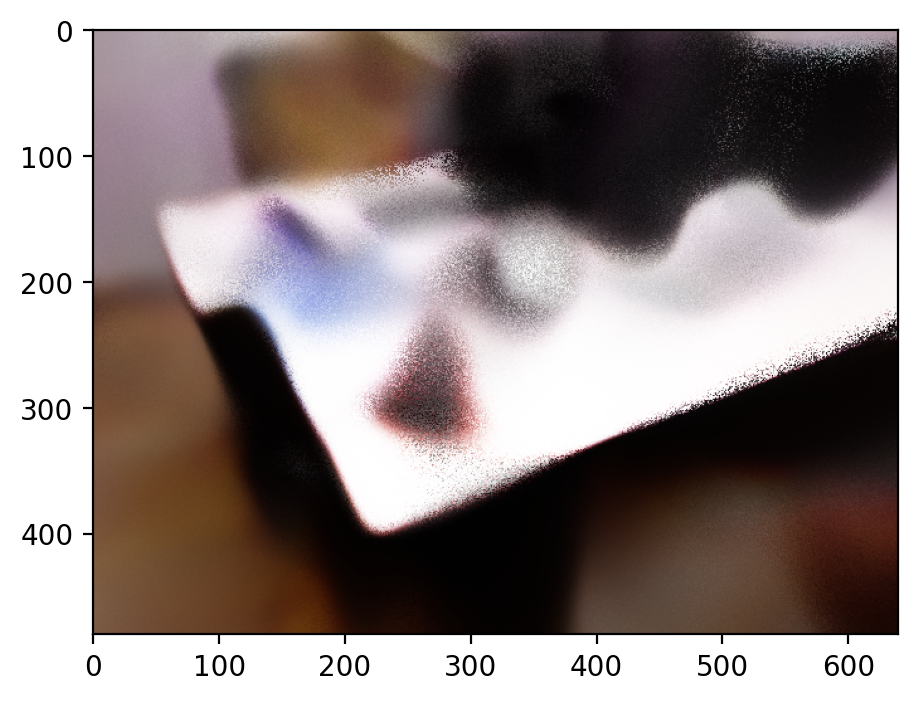

In [152]:
reconstructed_image = torch.cat(output_course_color, dim=0).reshape(480 // scale, 640 // scale, 3).detach().cpu().numpy()
mean = data_module.camera_info()._color_mean
std = data_module.camera_info()._color_std
reconstructed_image = reconstructed_image * std[None, None] + mean[None, None]
reconstructed_image = np.clip(reconstructed_image / 255., 0, 1)
figure = plt.figure(dpi=200)
plt.imshow(cv2.cvtColor(reconstructed_image.astype(np.float32), cv2.COLOR_RGB2BGR))

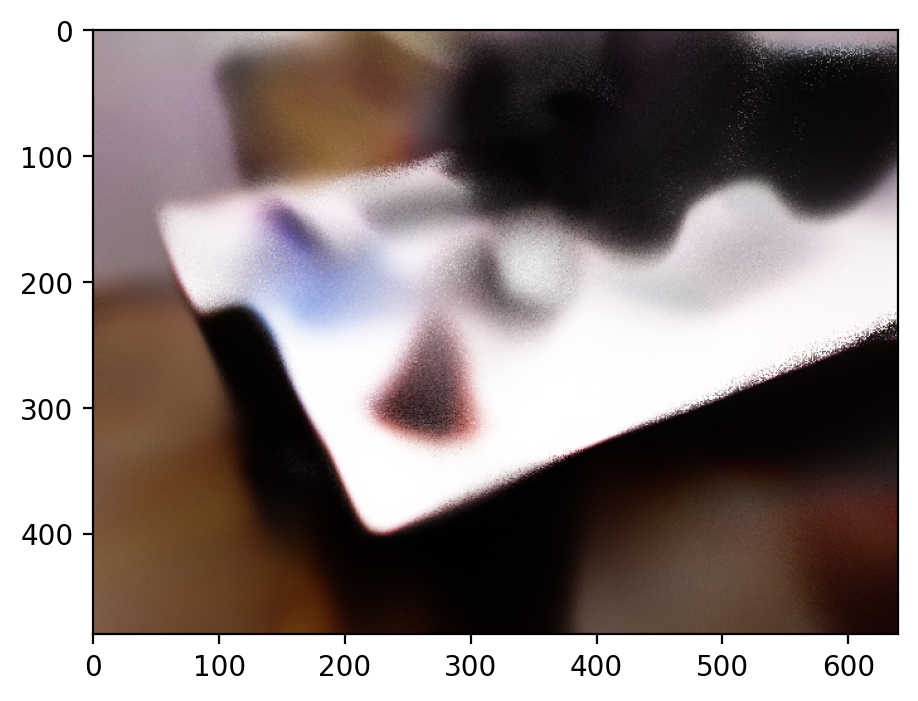

In [153]:
reconstructed_image = torch.cat(output_fine_color, dim=0).reshape(480 // scale, 640 // scale, 3).detach().cpu().numpy()
mean = data_module.camera_info()._color_mean
std = data_module.camera_info()._color_std
reconstructed_image = reconstructed_image * std[None, None] + mean[None, None]
reconstructed_image = np.clip(reconstructed_image / 255., 0, 1)
figure = plt.figure(dpi=200)
plt.imshow(cv2.cvtColor(reconstructed_image.astype(np.float32), cv2.COLOR_RGB2BGR))

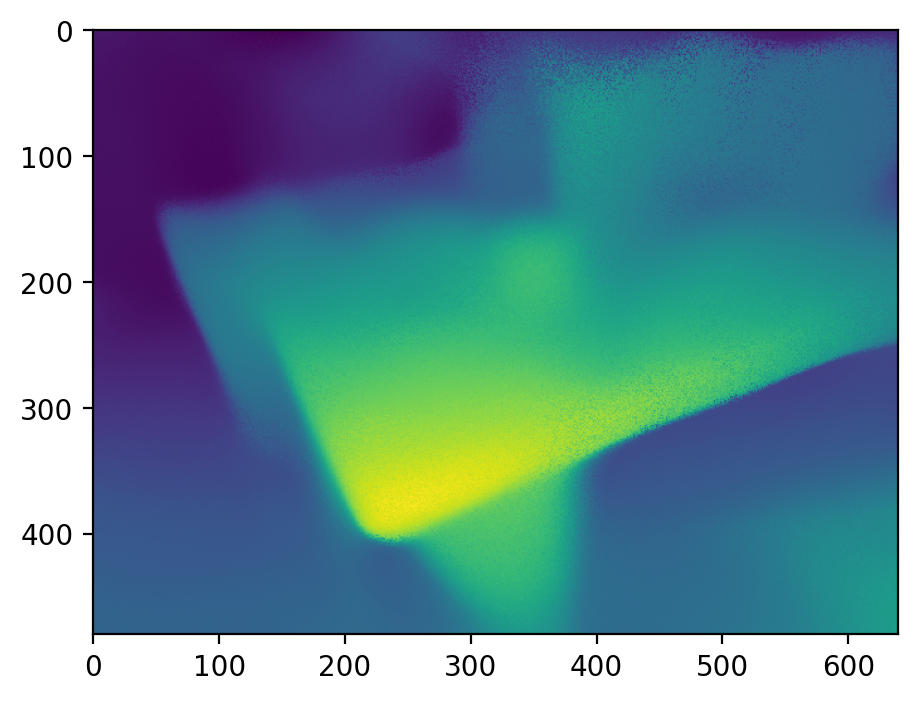

In [154]:
reconstructed_depth = torch.cat(output_course_depth, dim=0).reshape(480 // scale, 640 // scale).detach().cpu().numpy()
figure = plt.figure(dpi=200)
plt.imshow(1. /reconstructed_depth)

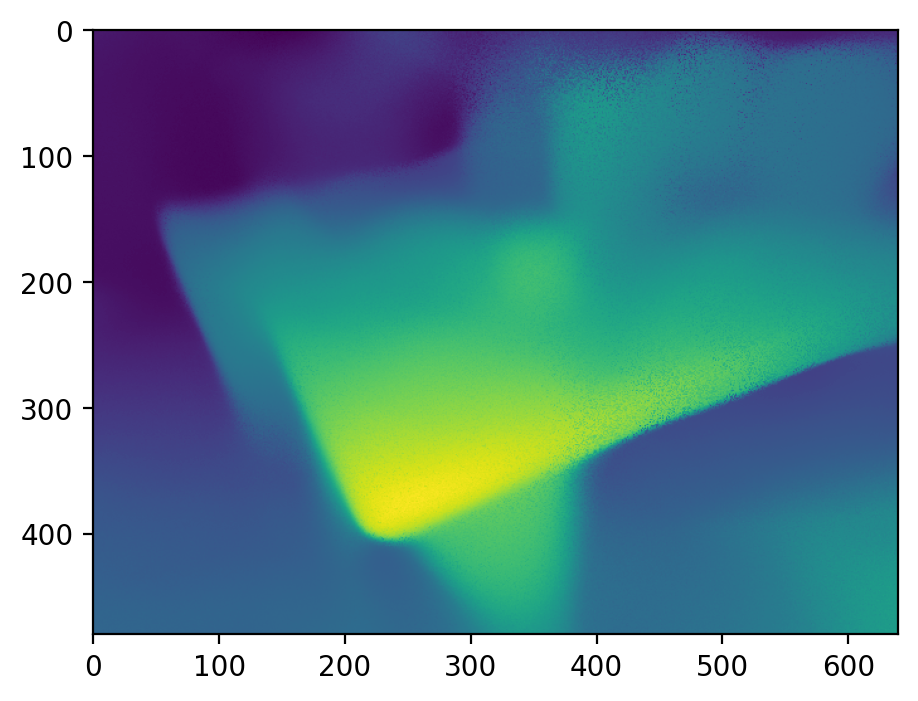

In [155]:
reconstructed_depth = torch.cat(output_fine_depth, dim=0).reshape(480 // scale, 640 // scale).detach().cpu().numpy()
figure = plt.figure(dpi=200)
plt.imshow(1. /reconstructed_depth)

# Test depth sampling

In [23]:
batch = None
for x in data_module.train_dataloader():
    batch = x
    break

In [24]:
image_index = 0
y = 304
x = 300
dataset_index = image_index * 480 * 640 + y * 640 + x
element = data_module._dataset[dataset_index]
pixel = torch.tensor(element['pixel']).cuda()[None]
camera_position = torch.tensor(element['camera_position']).cuda()[None]
truth_depth = torch.tensor(element['depth']).cuda()[None]

In [25]:
# pixel = batch['pixel'].cuda()
# camera_position = batch['camera_position'].cuda()
# truth_depth = batch['depth'].cuda()
course_sampled_depths = model.stratified_sample_depths(
    pixel.shape[0],
    pixel.device,
    model.hparams.course_sample_bins,
    False)
model = model.cuda()

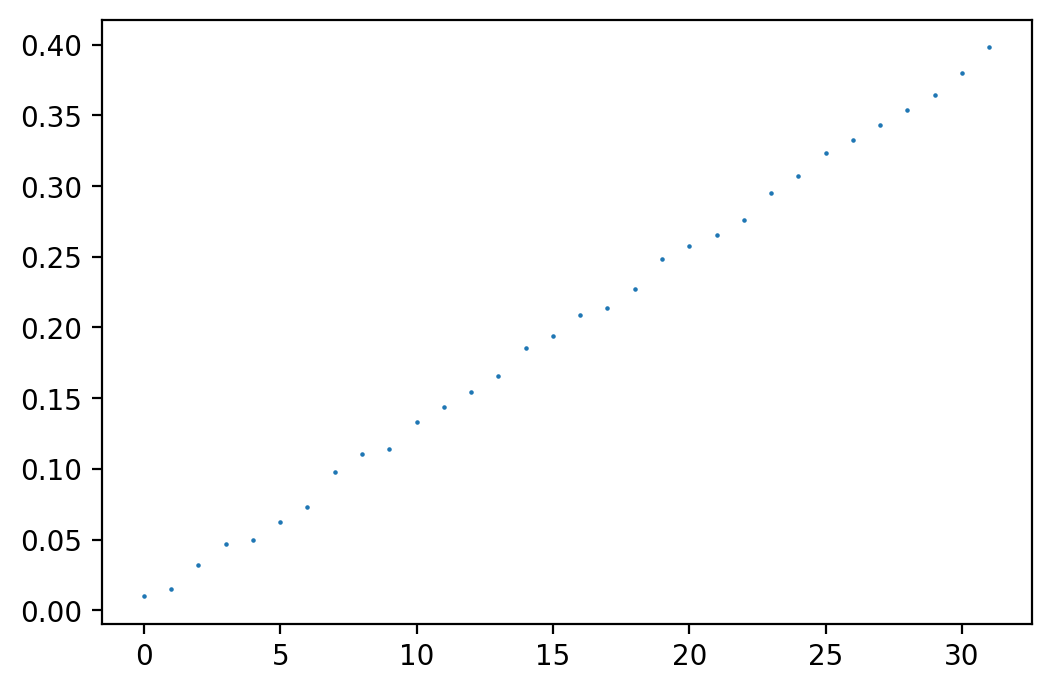

In [26]:
plt.figure(dpi=200)
plotted_depths = course_sampled_depths[:, 0].detach().cpu().numpy()
plt.scatter(np.arange(plotted_depths.shape[0]), plotted_depths, s=0.4)

In [27]:
course_color, course_depths, course_weights, course_depth_variance = model.reconstruct_color_and_depths(
    course_sampled_depths,
    pixel,
    camera_position,
    model._mlp)

In [28]:
bins_count = course_sampled_depths.shape[0]
sampled_depths = torch.sort(course_sampled_depths, dim=0).values
sampled_depths = course_sampled_depths.reshape(-1)
pixels1 = model.repeat_tensor(pixel, bins_count)
camera_positions1 = model.repeat_tensor(camera_position, bins_count)
back_projected_points = back_project_pixel(pixels1, sampled_depths, camera_positions1,
                                           model._inverted_camera_matrix)
encodings = model._positional_encoding(back_projected_points)
prediction = model._mlp(encodings)

colors = prediction[:, :3].reshape(bins_count, -1, 3)
density = prediction[:, 3].reshape(bins_count, -1)

logsumexp_density = torch.logsumexp(torch.cat([torch.zeros_like(density)[None], density[None]], dim=0), dim=0)

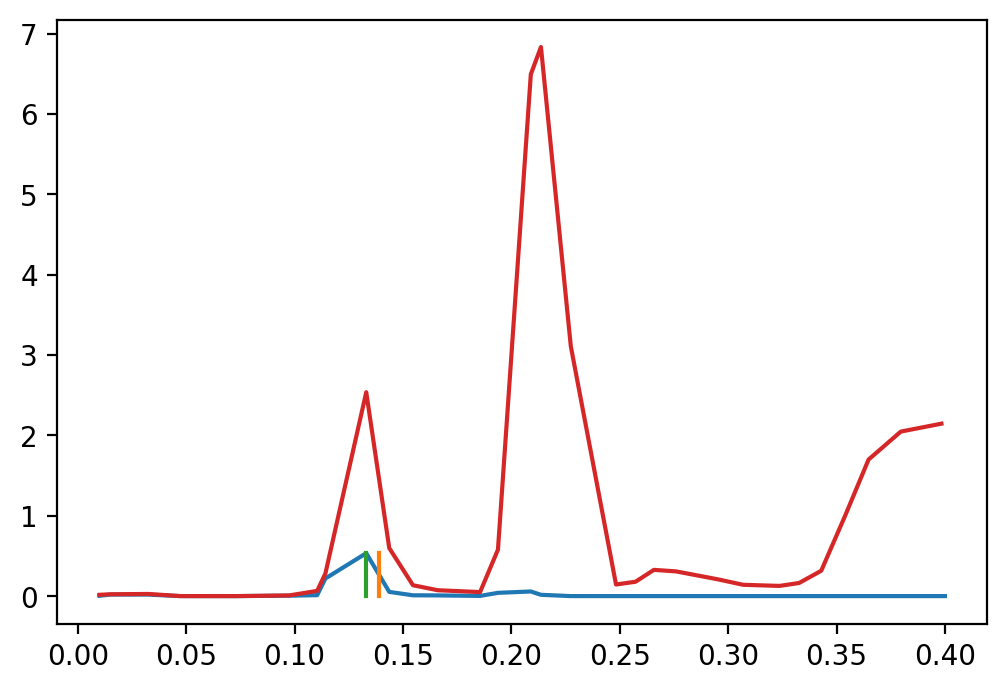

In [29]:
plt.figure(dpi=200)
index = 0
plotted_depths = course_sampled_depths[:, index].detach().cpu().numpy()
plotted_depths = np.append(plotted_depths, 0.4)
plotted_weigths = course_weights[:, index].detach().cpu().numpy()
plotted_truth_depth = truth_depth[index].detach().cpu().numpy()
plotted_density = logsumexp_density[:, index].detach().cpu().numpy()
mean_depth = np.sum(plotted_depths * plotted_weigths)
plt.plot(plotted_depths, plotted_weigths)
plt.plot([plotted_truth_depth, plotted_truth_depth], [0, np.max(plotted_weigths)])
plt.plot([mean_depth, mean_depth], [0, np.max(plotted_weigths)])
plt.plot(plotted_depths[:-1], plotted_density / 50.)

In [30]:
fine_sampled_depths = model.hierarchical_sample_depths(
    course_weights,
    pixel.shape[0],
    pixel.device,
    50,
    course_sampled_depths,
    False)

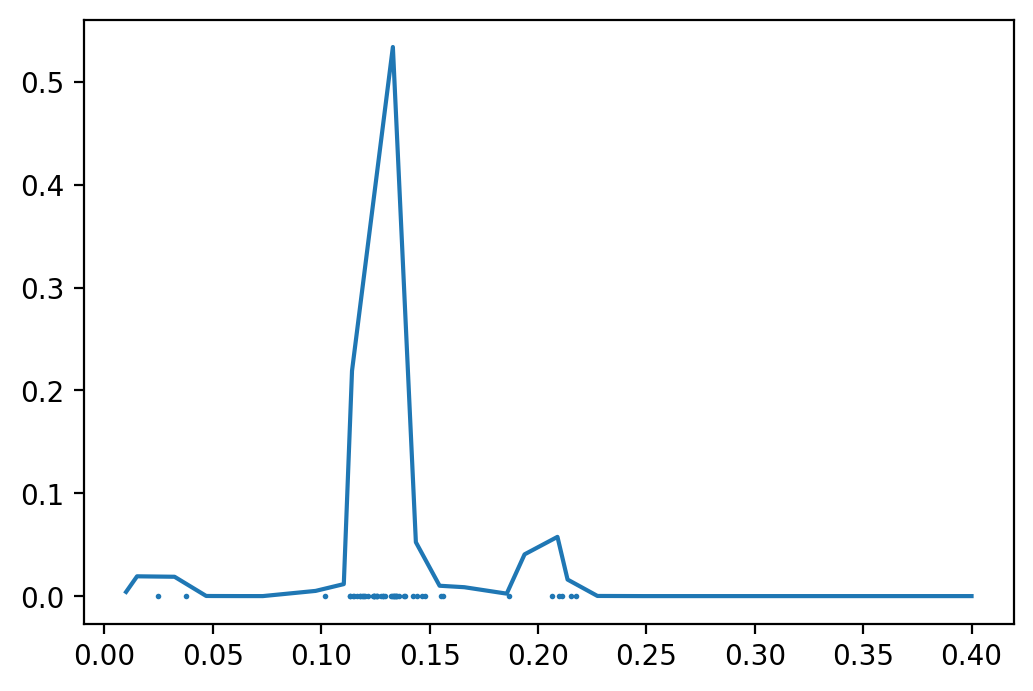

In [31]:
plt.figure(dpi=200)
index = 0
plotted_course_depths = course_sampled_depths[:, index].detach().cpu().numpy()
plotted_course_depths = np.append(plotted_course_depths, 0.4)
plotted_fine_depths = fine_sampled_depths[:, index].detach().cpu().numpy()
plotted_weigths = course_weights[:, index].detach().cpu().numpy()
plt.plot(plotted_course_depths, plotted_weigths)
plt.scatter(plotted_fine_depths, np.zeros_like(plotted_fine_depths), s=1)

In [32]:
with torch.no_grad():
    fine_color, fine_depths, fine_weights, fine_depth_variance = model.reconstruct_color_and_depths(
        fine_sampled_depths,
        pixel,
        camera_position,
        model._mlp)

In [33]:
bins_count = fine_sampled_depths.shape[0]
sampled_depths = torch.sort(fine_sampled_depths, dim=0).values
sampled_depths = fine_sampled_depths.reshape(-1)
pixels1 = model.repeat_tensor(pixel, bins_count)
camera_positions1 = model.repeat_tensor(camera_position, bins_count)
back_projected_points = back_project_pixel(pixels1, sampled_depths, camera_positions1,
                                           model._inverted_camera_matrix)
encodings = model._positional_encoding(back_projected_points)
prediction = model._mlp(encodings)

colors = prediction[:, :3].reshape(bins_count, -1, 3)
density = prediction[:, 3].reshape(bins_count, -1)

fine_logsumexp_density = torch.logsumexp(torch.cat([torch.zeros_like(density)[None], density[None]], dim=0), dim=0)

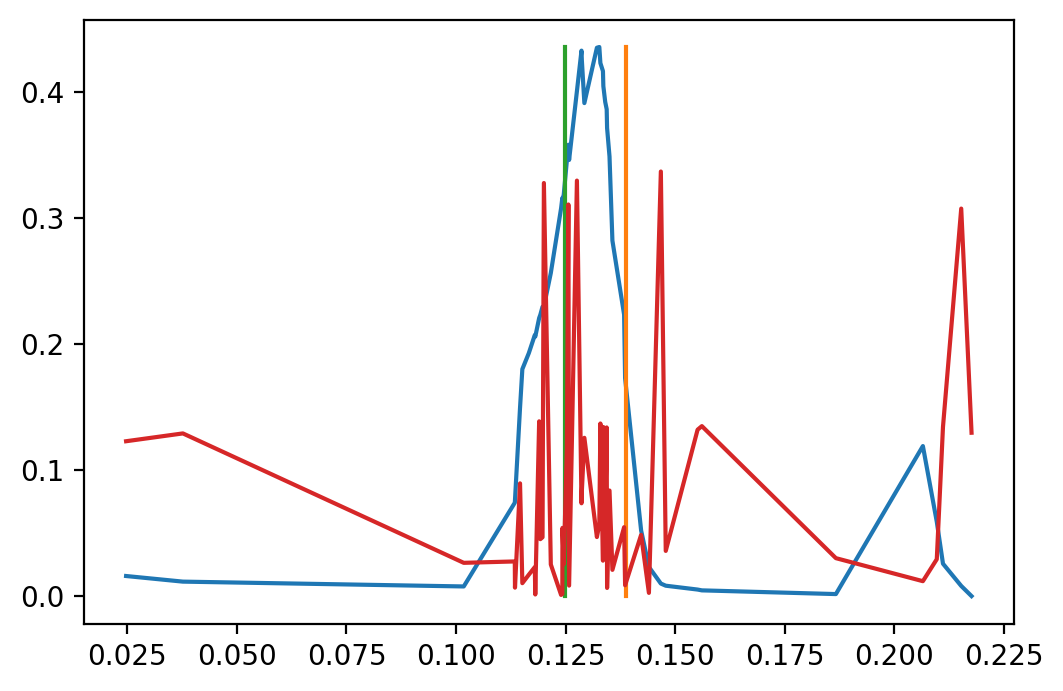

In [34]:
plt.figure(dpi=200)
index = 0
plotted_depths = torch.sort(fine_sampled_depths[:, index], dim=0).values.detach().cpu().numpy()
depth_deltas =  np.roll(plotted_depths, -1) - plotted_depths
plotted_weigths = fine_weights[:, index].detach().cpu().numpy()[:-1]
plotted_truth_depth = truth_depth[index].detach().cpu().numpy()
mean_depth = np.sum(plotted_depths * plotted_weigths)

plt.plot(plotted_depths, plotted_weigths / depth_deltas / 100)

plt.plot([plotted_truth_depth, plotted_truth_depth], [0, np.max(plotted_weigths / depth_deltas / 100)])
plt.plot([mean_depth, mean_depth], [0, np.max(plotted_weigths / depth_deltas / 100)])

plotted_density = fine_logsumexp_density[:, index].detach().cpu().numpy()
plt.plot(plotted_depths, plotted_density / 1000)